In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, re
from scipy.optimize import curve_fit
import scipy.optimize
from functions import *

In [2]:
def sinusoidal(x, A, B, C, D):
    return A * np.sin(B * x + C) + D

In [3]:
def fit_sin(tt, yy):
    
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    # def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinusoidal, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

In [4]:
def analyse(file):
    
    data = pd.read_csv(file, delimiter=";", decimal=',', encoding='ISO-8859-1')
    
    x = data['Stage position (µm)']
    y = data['Coincidence rate (Hz) - T&B']
    initial_guess = [100, 2, 0, 250]
    
    params = fit_sin(x, y)
    
    return params, x, y
    

In [5]:
file_path = [f for f in os.listdir('QT01/measurement 2') if re.match(r'michelson([-]?[0-9]{2})?.csv', f)]
file_path.sort()
visibility = list()

for file in file_path:
    
    param, x, y = analyse(os.path.join("QT01/measurement 2", file))
    try:
        adjuster_pos = int(file.split('.')[0][9:])
    except:
        adjuster_pos = 0
    
    A_fit, B_fit, C_fit, D_fit = param['amp'], param['omega'], param['phase'], param['offset']
    
    C_max = D_fit + A_fit
    C_min = D_fit - A_fit

    # error calculation
    dC_max = np.sqrt(C_max)
    dC_min = np.sqrt(C_min)
    V_error = 2/(C_max + C_min)**2 * np.sqrt(C_min**2 * dC_max**2 + C_max**2 * dC_min**2)
    res = get_oscillation_parameters_from_dataframe(read_interferogram(os.path.join("QT01/measurement 2", file)))

    # visibility.append([adjuster_pos, abs(res['visibility']), res['sd_raw_visibility']])
    visibility.append([adjuster_pos, abs((C_max - C_min)/(C_max + C_min)), V_error])

V = pd.DataFrame(visibility, index=None)
V.sort_values(by=[0], inplace=True)

In [6]:
V

,0,1,2
5,-60,0.122454,0.045124
4,-50,0.073140,0.045133
3,-40,0.163043,0.044548
2,-30,0.484073,0.039569
1,-20,0.788027,0.027823
0,-10,0.955110,0.013498
6,0,0.838295,0.024473
7,10,0.534739,0.038304
8,20,0.141906,0.044369
9,30,0.092080,0.044872


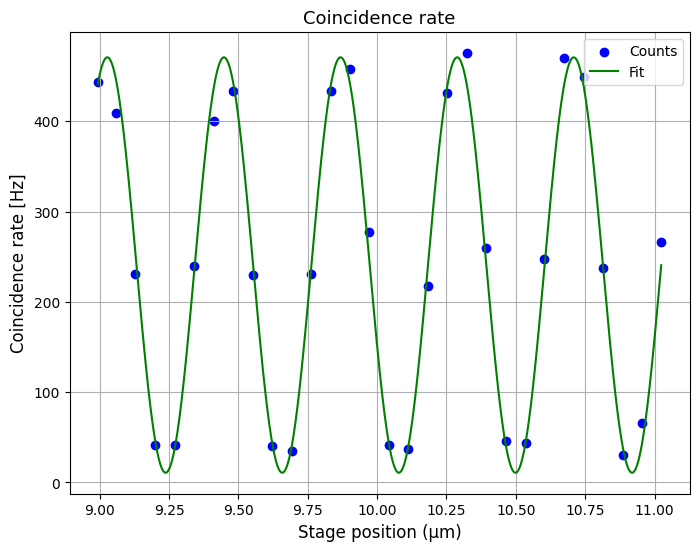

In [7]:
param, x, y = analyse(os.path.join("QT01/measurement 2", file_path[0]))
A_fit, B_fit, C_fit, D_fit = param['amp'], param['omega'], param['phase'], param['offset']
x_fit = np.arange(x.min(), x.max(), 0.001)
y_fit = sinusoidal(x_fit, A_fit, B_fit, C_fit, D_fit)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', label='Counts')
plt.plot(x_fit, y_fit, color='green', label='Fit')
plt.title('Coincidence rate', fontsize=13)
plt.xlabel('Stage position (µm)', fontsize=12)
plt.ylabel('Coincidence rate [Hz]', fontsize=12)
plt.legend()
plt.grid()
# plt.savefig('interferogram.png', dpi=300)

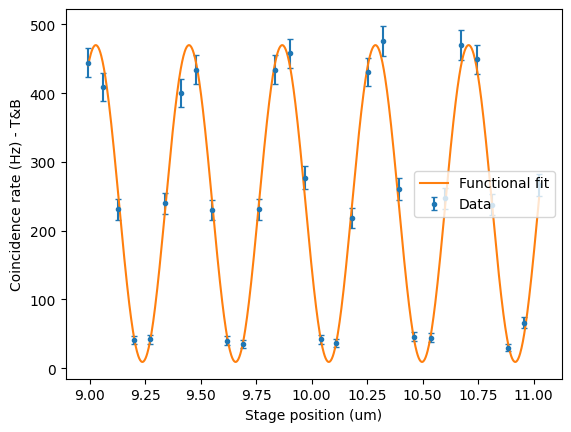

In [8]:
res = get_oscillation_parameters_from_interferogram(os.path.join("QT01/measurement 2", file_path[0]))
fig, ax = fit_and_plot_interferogram(os.path.join("QT01/measurement 2", file_path[0]), label='Functional fit')
fig.savefig('interferogram.png', dpi=300)

In [9]:
def sinc_fun(t, t0, a, w):
    return abs(a * np.sinc(w*(t-t0)))

In [10]:
init = [-10, 0.8, 0.04]
params, p_conv = curve_fit(sinc_fun, V[0], V[1], p0=init)

In [11]:
params

array([-9.48369223,  1.0005941 ,  0.03441896])

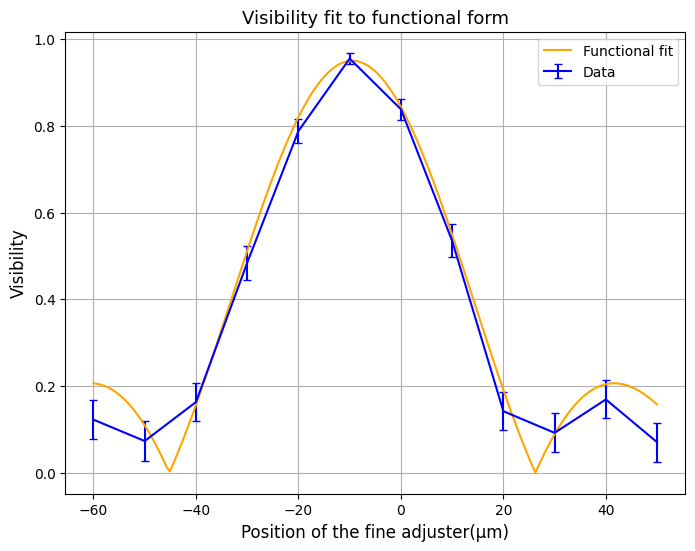

In [12]:
x = np.linspace(-60, 50, 200)

plt.figure(figsize=(8, 6))
plt.errorbar(V[0], V[1], yerr=V[2], capsize=3, color='blue', label='Data')
plt.plot(x, abs(0.95*np.sinc(0.028*(x+9.48))), color='orange', label='Functional fit')
# plt.plot(x, sinc_fun(x, *params), color='green', label='Fit')
plt.title('Visibility fit to functional form', fontsize=13)
plt.xlabel('Position of the fine adjuster(µm)', fontsize=12)
plt.ylabel('Visibility', fontsize=12)
plt.legend()
plt.grid()
plt.savefig('visibility.png', dpi=300)

In [22]:
for f in file_path:
    
    res = get_oscillation_parameters_from_dataframe(read_interferogram(os.path.join("QT01/measurement 2", f)))
    print(f, abs(res['visibility']))

michelson-10.csv 0.9621923024153063
michelson-20.csv 0.7983668941381679
michelson-30.csv 0.48368251399560497
michelson-40.csv 0.16455135667524515
michelson-50.csv 0.0739463717999178
michelson-60.csv 0.12188351569563174
michelson.csv 0.8504430989140896
michelson10.csv 0.5337816082893355
michelson20.csv 0.1416037502079086
michelson30.csv 0.09248002519213373
michelson40.csv 0.1723048455505132
michelson50.csv 0.07067569415781853


In [15]:
abs(0.95*np.sinc(0.028*(x+9.48))).max()

np.float64(0.9499415138465049)

In [16]:
V

,0,1,2
5,-60,0.122454,0.045124
4,-50,0.073140,0.045133
3,-40,0.163043,0.044548
2,-30,0.484073,0.039569
1,-20,0.788027,0.027823
0,-10,0.955110,0.013498
6,0,0.838295,0.024473
7,10,0.534739,0.038304
8,20,0.141906,0.044369
9,30,0.092080,0.044872
